In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\kamde\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [27]:
df = pd.read_csv("synthetic_predictive_maintenance_portfolio.csv")
df.head()

,machineID,timestamp,temperature_C,pressure_bar,vibration_mm_s,runtime_hours,power_kW,torque_Nm,humidity_pct,oil_quality_score,...,fan_speed_rpm,cooling_rate_C_sec,ambient_temp_C,gas_flow_m3_h,dust_level_index,sensor_faults,voltage_fluctuation_pct,thermal_stress_index,maintenance_count,failure_within_30d
0,7,2023-04-22 09:19:00,54.260939950283536,3.794329,0.7135498370363585,1385,197.533116,401.895893,61.901647,0.262071,...,1284.561440,2.472714,18.312136,67.365011,38.313966,0,1.145076,47.417483,6,1
1,20,2023-04-11 21:21:00,57.38757421363357,5.395100,0.6781258280768983,1563,194.372373,361.162653,44.962107,0.766424,...,1088.315771,2.276585,25.793010,76.168426,55.404987,0,1.089491,61.129212,8,1
2,15,2023-05-05 15:55:00,77.5913365508434,5.665597,0.6284855170646071,2291,173.281224,431.151665,57.022879,0.653272,...,1373.008888,2.008043,27.091075,84.735276,87.140786,0,1.408590,65.381609,2,1
3,11,2023-01-11 10:29:00,70.1533274126656,3.403232,0.6438901188009029,2033,189.216414,389.741541,42.732718,0.945167,...,1304.780556,3.004230,18.663026,77.816550,54.772326,0,1.324168,57.307158,6,1
4,8,2023-05-27 04:35:00,68.80044302686382,4.284320,0.6777050012403512,1927,138.813239,356.494690,60.025218,0.464947,...,1187.705465,2.658552,21.507138,79.121249,49.129455,1,1.322413,39.857238,6,1


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   machineID                5000 non-null   int64  
 1   timestamp                5000 non-null   object 
 2   temperature_C            5000 non-null   object 
 3   pressure_bar             5000 non-null   float64
 4   vibration_mm_s           5000 non-null   object 
 5   runtime_hours            5000 non-null   int64  
 6   power_kW                 5000 non-null   float64
 7   torque_Nm                5000 non-null   float64
 8   humidity_pct             5000 non-null   float64
 9   oil_quality_score        5000 non-null   float64
 10  load_weight_kg           5000 non-null   float64
 11  cycle_time_sec           5000 non-null   float64
 12  fan_speed_rpm            5000 non-null   float64
 13  cooling_rate_C_sec       5000 non-null   float64
 14  ambient_temp_C          

In [29]:
df.replace("?", np.nan, inplace = True)

In [30]:
df.isnull().sum().sort_values(ascending=False)

temperature_C              28
vibration_mm_s             20
timestamp                   0
machineID                   0
pressure_bar                0
runtime_hours               0
power_kW                    0
torque_Nm                   0
humidity_pct                0
oil_quality_score           0
load_weight_kg              0
cycle_time_sec              0
fan_speed_rpm               0
cooling_rate_C_sec          0
ambient_temp_C              0
gas_flow_m3_h               0
dust_level_index            0
sensor_faults               0
voltage_fluctuation_pct     0
thermal_stress_index        0
maintenance_count           0
failure_within_30d          0
dtype: int64

In [31]:
df["temperature_C"] = df["temperature_C"].astype(float).fillna(df['temperature_C'].astype(float).mean())

In [32]:
df["vibration_mm_s"] = df["vibration_mm_s"].astype(float).fillna(df["vibration_mm_s"].astype(float).mean())

In [33]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
#df['month'] = df['timestamp'].dt.month
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

In [34]:
df["sensor_faults"].describe()

count    5000.000000
mean        0.196600
std         0.438163
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: sensor_faults, dtype: float64

In [35]:
df.head()

,machineID,timestamp,temperature_C,pressure_bar,vibration_mm_s,runtime_hours,power_kW,torque_Nm,humidity_pct,oil_quality_score,...,gas_flow_m3_h,dust_level_index,sensor_faults,voltage_fluctuation_pct,thermal_stress_index,maintenance_count,failure_within_30d,hour,day_of_week,is_weekend
0,7,2023-04-22 09:19:00,54.260940,3.794329,0.713550,1385,197.533116,401.895893,61.901647,0.262071,...,67.365011,38.313966,0,1.145076,47.417483,6,1,9,5,1
1,20,2023-04-11 21:21:00,57.387574,5.395100,0.678126,1563,194.372373,361.162653,44.962107,0.766424,...,76.168426,55.404987,0,1.089491,61.129212,8,1,21,1,0
2,15,2023-05-05 15:55:00,77.591337,5.665597,0.628486,2291,173.281224,431.151665,57.022879,0.653272,...,84.735276,87.140786,0,1.408590,65.381609,2,1,15,4,0
3,11,2023-01-11 10:29:00,70.153327,3.403232,0.643890,2033,189.216414,389.741541,42.732718,0.945167,...,77.816550,54.772326,0,1.324168,57.307158,6,1,10,2,0
4,8,2023-05-27 04:35:00,68.800443,4.284320,0.677705,1927,138.813239,356.494690,60.025218,0.464947,...,79.121249,49.129455,1,1.322413,39.857238,6,1,4,5,1


In [36]:
scaler = StandardScaler()

In [37]:
df.drop(["timestamp", "machineID"], axis = 1, inplace = True)

In [38]:
df.columns

Index(['temperature_C', 'pressure_bar', 'vibration_mm_s', 'runtime_hours',
       'power_kW', 'torque_Nm', 'humidity_pct', 'oil_quality_score',
       'load_weight_kg', 'cycle_time_sec', 'fan_speed_rpm',
       'cooling_rate_C_sec', 'ambient_temp_C', 'gas_flow_m3_h',
       'dust_level_index', 'sensor_faults', 'voltage_fluctuation_pct',
       'thermal_stress_index', 'maintenance_count', 'failure_within_30d',
       'hour', 'day_of_week', 'is_weekend'],
      dtype='object')

In [39]:
scaler.fit(df.drop(["failure_within_30d"], axis = 1))
features_scaled = scaler.transform(df.drop(["failure_within_30d"], axis = 1))

In [40]:
X = features_scaled
y = df["failure_within_30d"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [41]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

In [42]:
print(confusion_matrix(y_test, dt_pred))
print(classification_report(y_test, dt_pred))

[[ 175   80]
 [  92 1153]]
              precision    recall  f1-score   support

           0       0.66      0.69      0.67       255
           1       0.94      0.93      0.93      1245

    accuracy                           0.89      1500
   macro avg       0.80      0.81      0.80      1500
weighted avg       0.89      0.89      0.89      1500



In [43]:
rfc = RandomForestClassifier(n_estimators = 200)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

In [44]:
print(confusion_matrix(y_test, rfc_pred))
print(classification_report(y_test, rfc_pred))

[[ 203   52]
 [  81 1164]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75       255
           1       0.96      0.93      0.95      1245

    accuracy                           0.91      1500
   macro avg       0.84      0.87      0.85      1500
weighted avg       0.92      0.91      0.91      1500



In [45]:
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


In [46]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")

grid_search = GridSearchCV(estimator = xgb, 
                        param_grid=param_grid,
                        scoring='f1_weighted',
                        cv=5,
                        verbose=2,
                        n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
    

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\kamde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:199: UserWarning: [10:46:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [47]:
tuned_pred = best_model.predict(X_test)

In [48]:
print(confusion_matrix(y_test, tuned_pred))
print(classification_report(y_test, tuned_pred))

[[ 200   55]
 [  86 1159]]
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       255
           1       0.95      0.93      0.94      1245

    accuracy                           0.91      1500
   macro avg       0.83      0.86      0.84      1500
weighted avg       0.91      0.91      0.91      1500



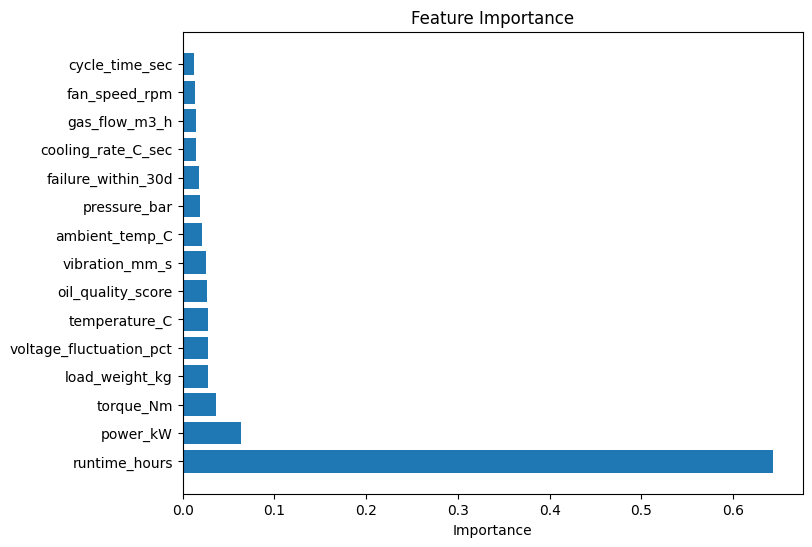

In [54]:
importances = best_model.feature_importances_
feature_names = df.columns

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 6))
plt.title("Feature Importance")
plt.barh(range(15), importances[indices[:15]][::-1])
plt.yticks(range(15), [feature_names[i] for i in indices[:15]][::-1])
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()